# Pre-process 12-lead ECG signal
Stefan/Yuzhao Heng
Since Wed. Nov. 17th, 2021


Signals from different sources need to be de-noised & unified


## Setup



ic| dnm: 'INCART'
    sig: array([ -9.84824903,  -9.91828794,  -9.91634241, ..., -10.77237354,
                -10.76070039, -10.71011673])
    sig.shape: (462600,)


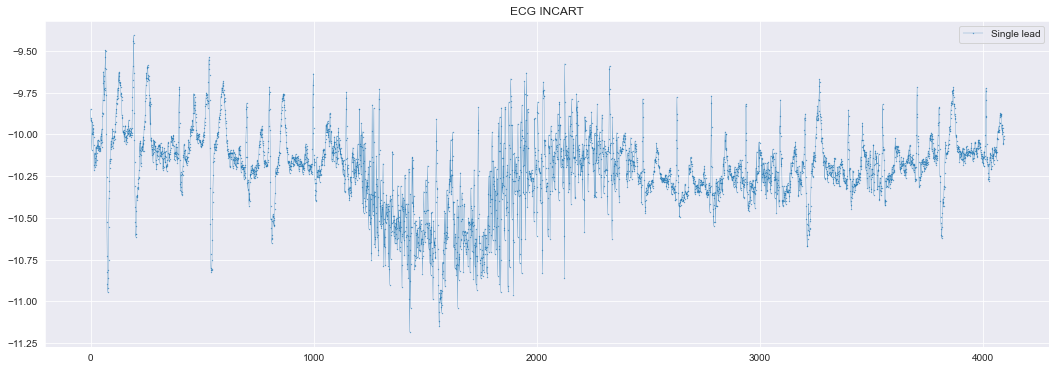

ic| dnm: 'PTB_XL'
    sig: array([-0.025, -0.025, -0.025, ...,  0.015,  0.015,  0.015])
    sig.shape: (5000,)


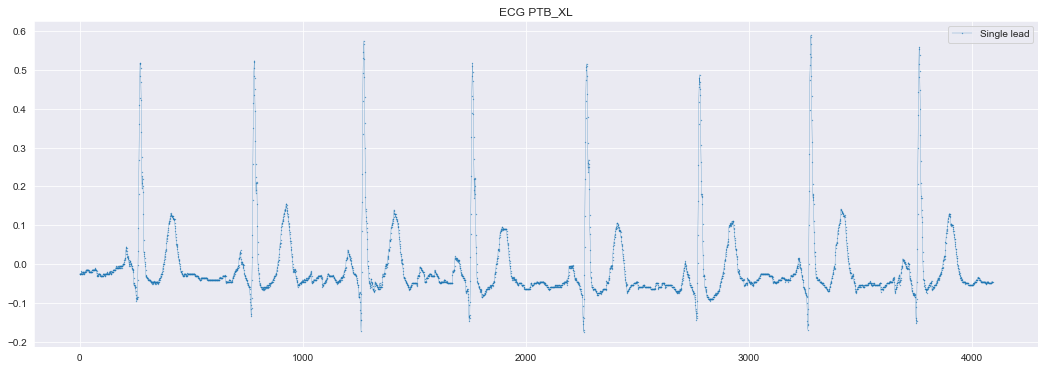

ic| dnm: 'PTB_Diagnostic'
    sig: array([-0.1035, -0.1005, -0.103 , ..., -0.1175, -0.1195, -0.114 ])
    sig.shape: (120012,)


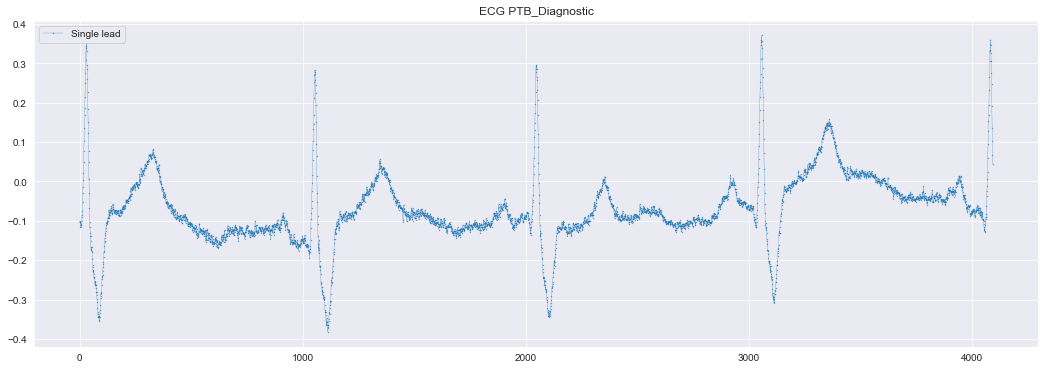

ic| dnm: 'CSPC_CinC'
    sig: array([-0.083, -0.117, -0.106, ..., -0.038, -0.036, -0.039])
    sig.shape: (5000,)


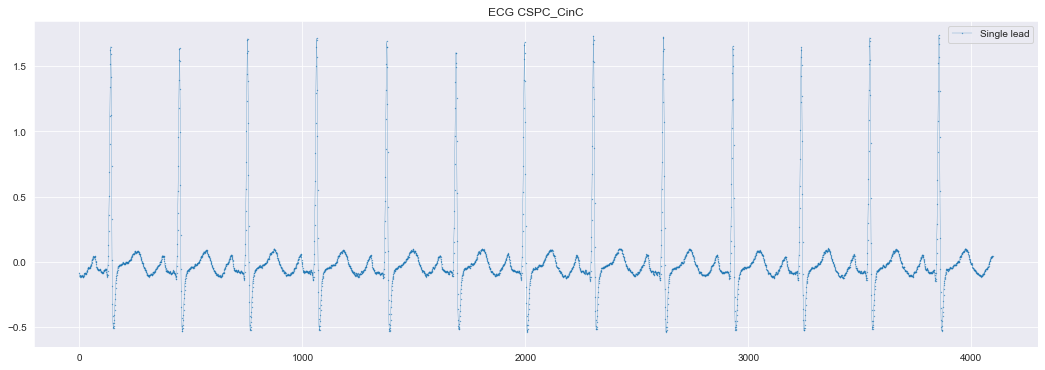

ic| dnm: 'CSPC_Extra_CinC'
    sig: array([-0.044, -0.031, -0.009, ...,  0.008,  0.007,  0.014])
    sig.shape: (11500,)


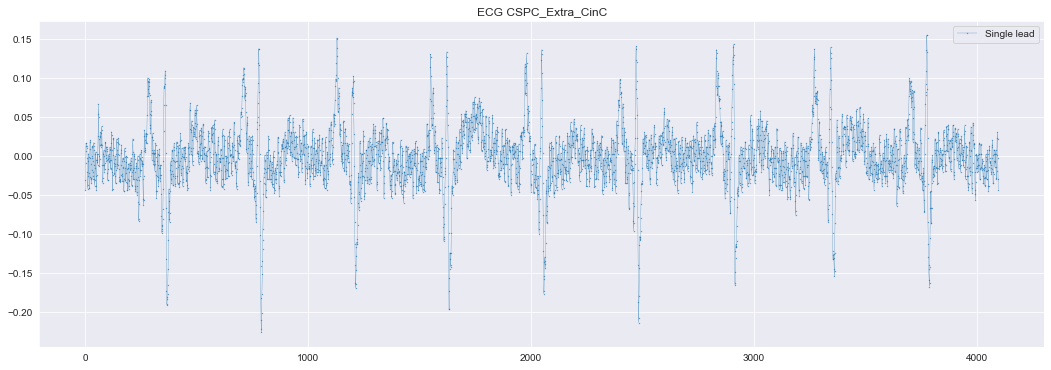

ic| dnm: 'G12EC'
    sig: array([-0.009, -0.009, -0.009, ...,  0.224,  0.273,  0.302])
    sig.shape: (5000,)


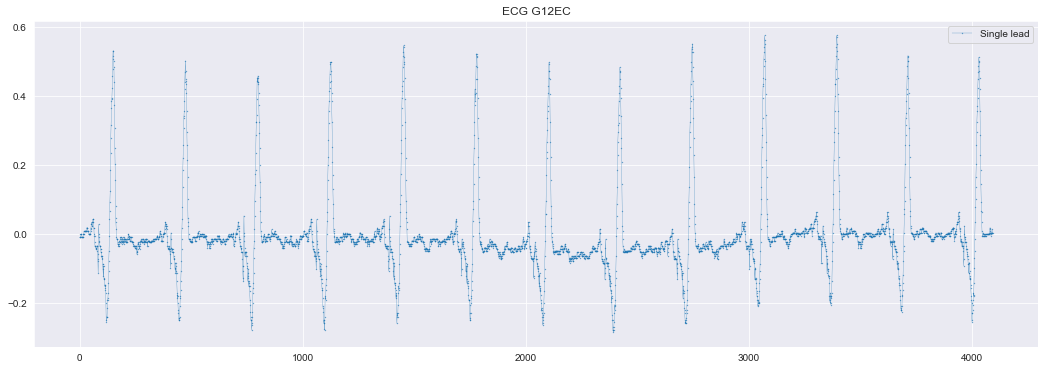

ic| dnm: 'CHAP_SHAO'
    sig: array([ -9.76, -19.52,  -9.76, ...,  14.64,  -4.88,   9.76])
    sig.shape: (5000,)


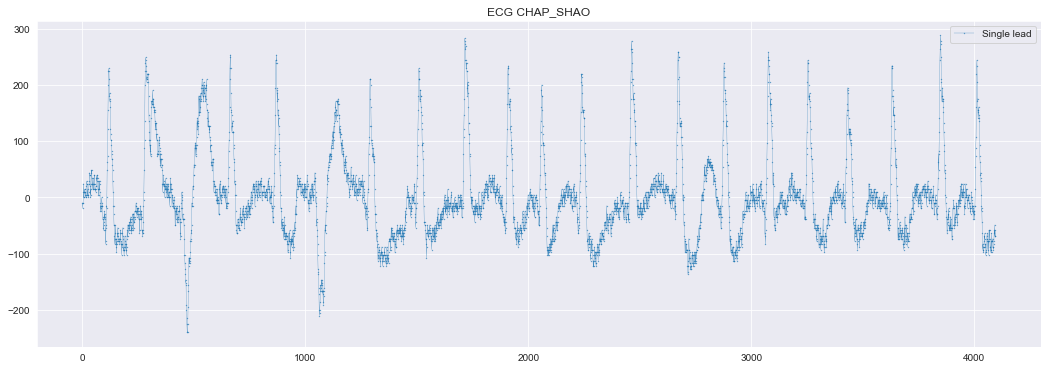

ic| dnm: 'CODE_TEST'
    sig: array([-0.96888648, -0.9746775 , -0.96799859, ..., -0.38833734,
                -0.38872384, -0.38226948])
    sig.shape: (4096,)


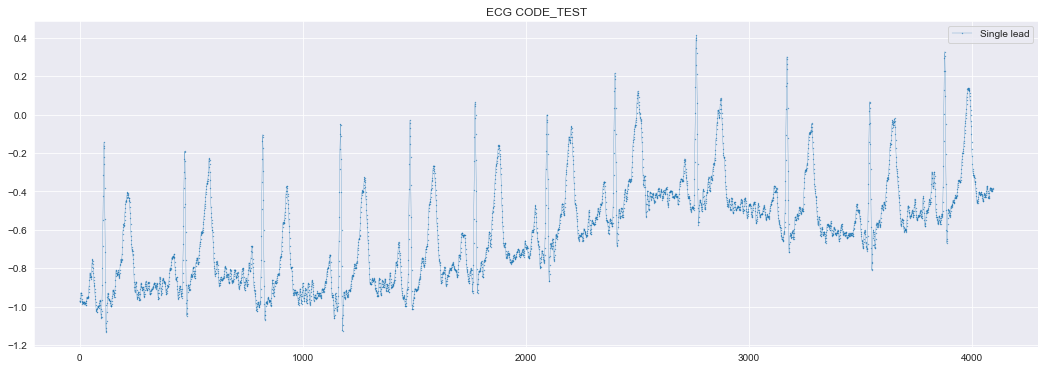

In [2]:
import math

import numpy as np
import pywt
from icecream import ic

from util import *


np.random.seed(config('random_seed'))


d_sig = dict()
for dnm in config('datasets_export.total'):
    sig = d_sig[dnm] = get_signal_eg(dnm=dnm)[:, 0]  # Single lead
    ic(dnm, sig, sig.shape)
    plot_single(sig[:2**12], label='Single lead', title=f'ECG {dnm}')



## Some signals indicative of noise



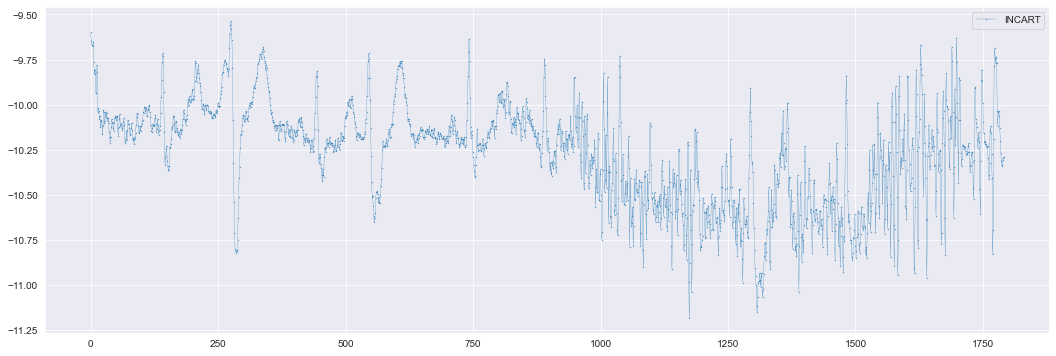

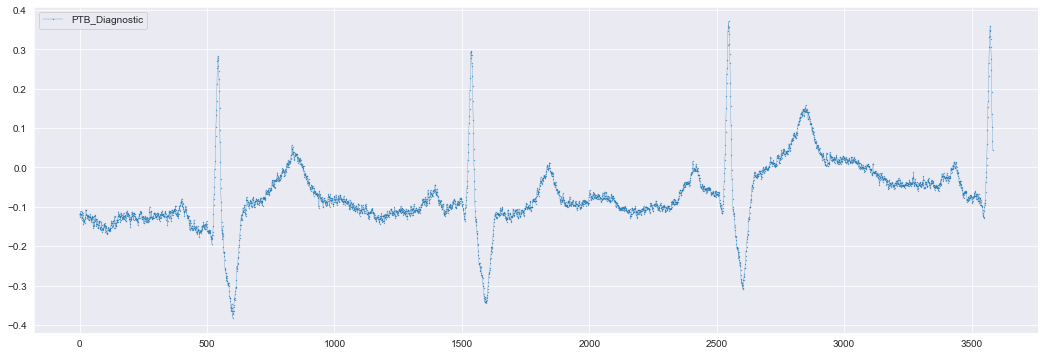

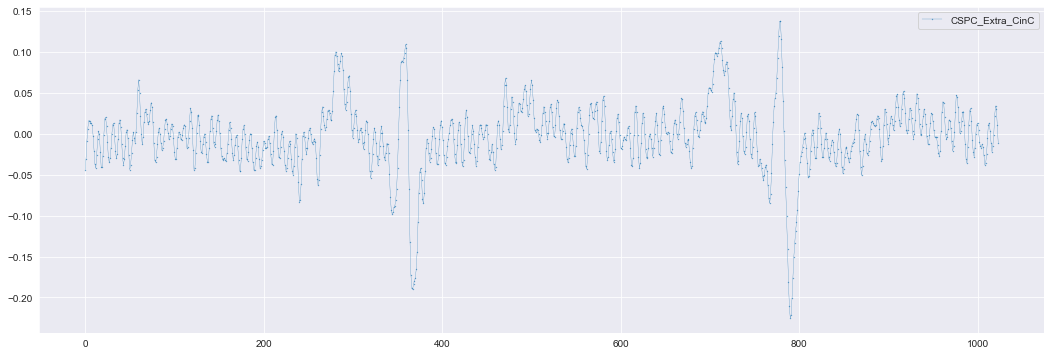

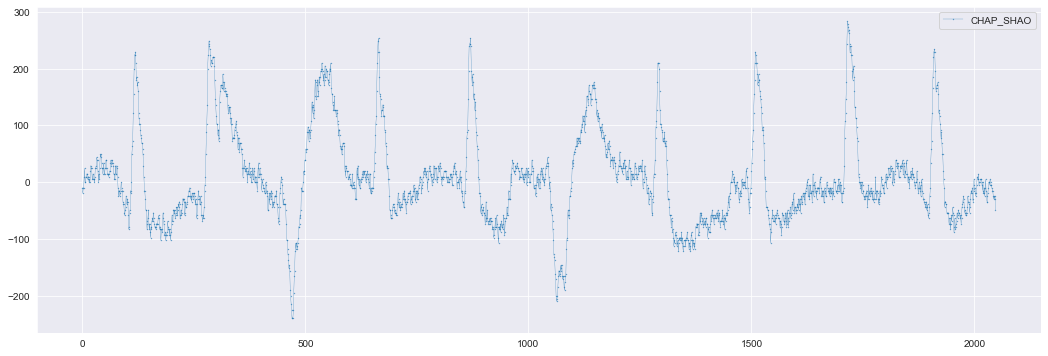

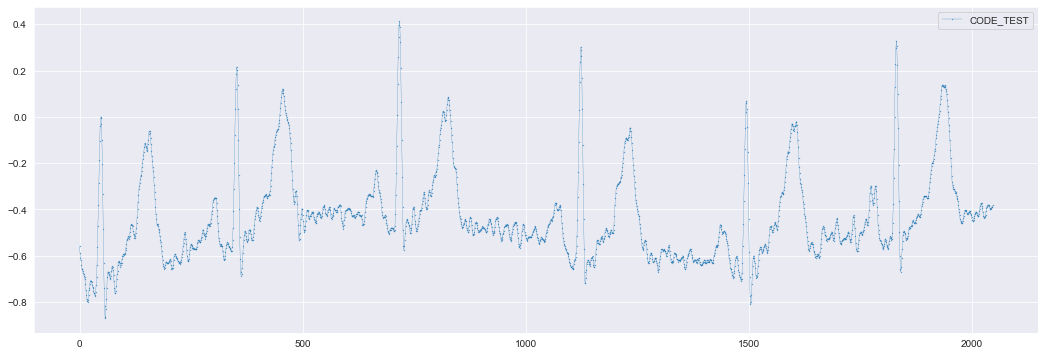

In [3]:
d_eg = {dnm: d_sig[dnm][s:e] for dnm, (s, e) in [
    ['INCART', (2**8,2**11)],
    ['PTB_Diagnostic', (2**9, 2**12)],
    ['CSPC_Extra_CinC', (0, 2**10)],
    ['CHAP_SHAO', (0, 2**11)],
    ['CODE_TEST', (2**11, 2**12)],
]}

for dnm, sig in d_eg.items():
    plot_single(sig, label=dnm)



## Remove noise
### Wavelet thresholding
Which wavelet, which threshold, how many levels to decompose?



ic| sig.max(): 0.137, sig.min(): -0.225


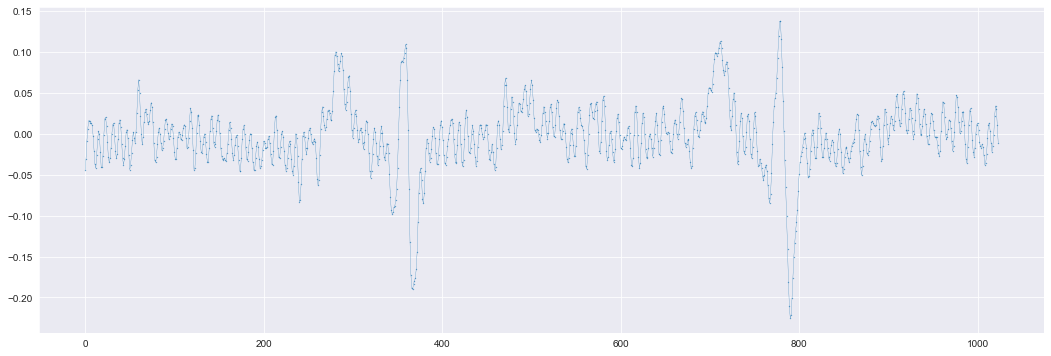

ic| pywt.dwt_max_level(l, w): 8, math.floor(math.log2(l)): 10
ic| threshold: 0.125
ic| list(map(lambda x: (x.min(), x.max()), coeffs)): [(-0.3329227936752994, 0.2563197329276882),
                                                      (-0.26335686126310387, 0.30693197159136515),
                                                      (-0.16240072951162546, 0.2933512643156962),
                                                      (-0.396423212120877, 0.4629480225244093),
                                                      (-0.12905197567807178, 0.1599650944920056),
                                                      (-0.051050948015713034, 0.05328059408747355),
                                                      (-0.013756396621779738, 0.018361881885183066)]


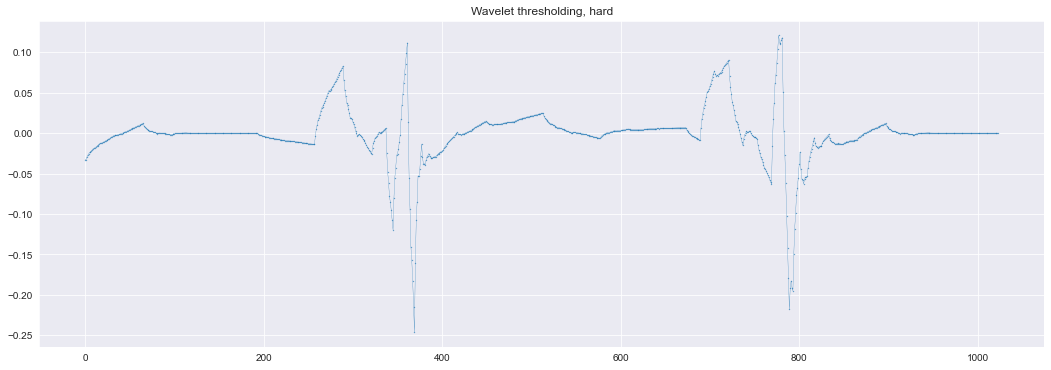

ic| list(map(lambda x: (x.min(), x.max()), coeffs)): [(-0.3329227936752994, 0.2563197329276882),
                                                      (-0.26335686126310387, 0.30693197159136515),
                                                      (-0.16240072951162546, 0.2933512643156962),
                                                      (-0.396423212120877, 0.4629480225244093),
                                                      (-0.12905197567807178, 0.1599650944920056),
                                                      (-0.051050948015713034, 0.05328059408747355),
                                                      (-0.013756396621779738, 0.018361881885183066)]


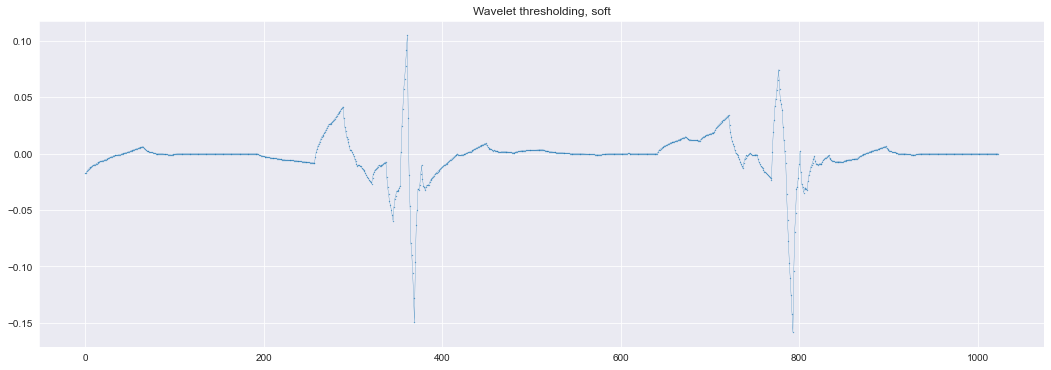

In [20]:
# sig = d_eg['CODE_TEST']
sig = d_eg['CSPC_Extra_CinC']
ic(sig.max(), sig.min())
plot_single(sig)


# w = 'db2'
w = 'sym2'
l = sig.shape[0]
level = 6
ic(pywt.dwt_max_level(l, w), math.floor(math.log2(l)))

def wv_threshold(sig, t, w='db2', level=6, mode='soft'):
    coeffs = pywt.wavedec(sig, w, level=level)
    coeffs_ = list(map(lambda x: pywt.threshold(x, t, mode=mode), coeffs))
    # coeffs_ = list(map(lambda x: pywt.threshold(x, math.sqrt(2 * math.log2(x.size)), mode=mode), coeffs))
    ic(list(map(lambda x: (x.min(), x.max()), coeffs)))
    return pywt.waverec(coeffs_, w)


threshold = 1 / 2**3  # Arbitrary
ic(threshold)
plot_single(wv_threshold(sig, threshold, level=level, mode='hard'), title='Wavelet thresholding, hard')
plot_single(wv_threshold(sig, threshold, level=level, mode='soft'), title='Wavelet thresholding, soft')


### NLM
Used in the paper *Optimal Multi-Stage Arrhythmia Classification Approach*,
the authors contributed ECG dataset of 40k records, so I assume a credible source

Looks like the same approach is in the paper *A 12-lead electrocardiogram database for arrhythmia research covering more than 10,000 patients*,
by the same group of researchers


#### Check performance



ic| df_de.head(6):         0        1        2        3       4        5       6       7   \
                   0  541.220  665.350  124.790 -602.710  206.09  396.500 -979.12 -1774.4   
                   1  427.810  392.100  -35.046 -409.670  229.83  179.740 -894.98 -1697.0   
                   2  318.830  138.640 -179.530 -228.710  248.03  -19.352 -808.46 -1602.8   
                   3  219.400  -76.361 -295.120  -71.727  256.44 -184.660 -717.97 -1478.5   
                   4  134.850 -237.560 -371.770   50.979  252.71 -303.560 -623.45 -1318.3   
                   5   69.024 -336.260 -404.660  133.130  236.41 -369.360 -526.20 -1125.1   
                   
                          8        9        10        11  
                   0 -2056.6  -386.81  2073.10  1276.600  
                   1 -2069.4  -761.90  1252.60   621.030  
                   2 -2055.8 -1092.20   503.58    24.539  
                   3 -1994.5 -1338.50  -112.37  -460.560  
                   4 -1874.6 -1474

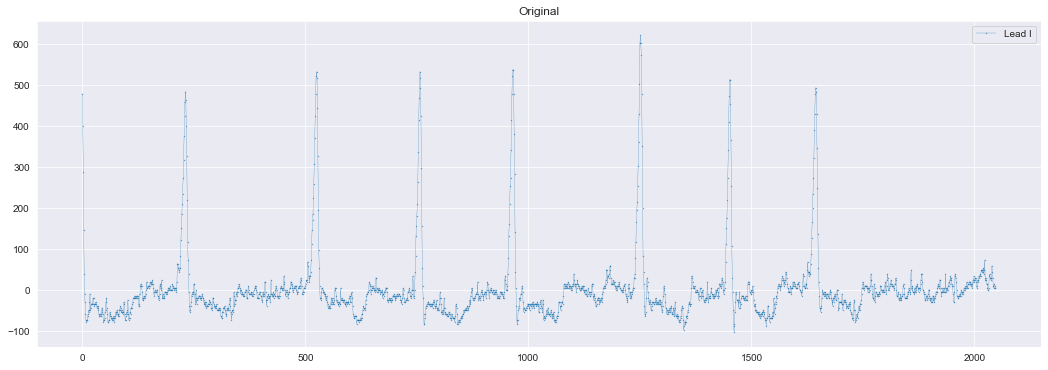

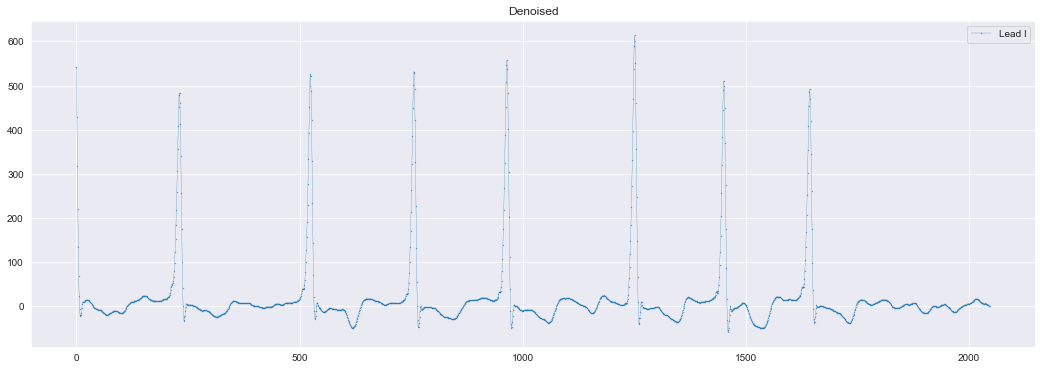

In [28]:
dnm = 'CHAP_SHAO'
fnm = get_rec_paths(dnm)[77]
df = pd.read_csv(fnm)
df_de = pd.read_csv(fnm.replace('ECGData', 'ECGDataDenoised'), header=None)
ic(df_de.head(6))
ic(df_de.iloc[:2**11, 0])
ic(fnm)

plot_single(df.iloc[:2**11]['I'], label='Lead I', title='Original')
plot_single(df_de.iloc[:2**11][0], label='Lead I', title='Denoised')

